## Lab: Forearm movements and PPO


In the previous lab, we were able to solve Bellman’s equation assuming linear dynamics as well as
quadratic costs. These assumptions are strong, and we might want to relax those for a more realistic
model. In this lab, we look at a model-free Reinforcement Learning algorithm known as PPO to solve
our optimization problem.
We are going to use a library called stable-baselines3 with an off-the-shelf implementation of PPO.
To be compatible with stable baselines, we will comply with the Gym API, which is a standard for
implementing RL environments.

### 1. Setting a virtual environment up

In [1]:
%pip install virtualenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!python3 -m virtualenv ~/myenv


created virtual environment CPython3.11.7.final.0-64 in 6758ms
  creator Venv(dest=C:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\~\myenv, clear=False, no_vcs_ignore=False, global=False, describe=CPython3Windows)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=C:\Users\laure\AppData\Local\pypa\virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,BatchActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [5]:
%env PATH=C:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\.env\bin;%PATH%
%pip install activate
#%env PATH=C:\Users\laure\Downloads\tp1 (3)\python\.env\bin;%PATH%


env: PATH=C:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\.env\bin;%PATH%
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: c:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\.env\Scripts\python.exe -m pip install --upgrade pip


In [6]:
%pip install stable-baselines3



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: c:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\.env\Scripts\python.exe -m pip install --upgrade pip


In [8]:
%pip install tensorboard


Note: you may need to restart the kernel to use updated packages.Collecting tensorboard
     ---------------------------------------- 0.0/181.3 kB ? eta -:--:--
     ------------------------------------ - 174.1/181.3 kB 5.3 MB/s eta 0:00:01
     -------------------------------------- 181.3/181.3 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/151.7 kB ? eta -:--:--
     ---------------------------------------- 151.7/151.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------- ----------------------------- 1.4/5.5 MB 31.2 MB/s eta 0:00:01
   ---------------------- ----------------- 3.2/5.5 MB 34.0 MB/s eta 0:00:01
   ----------------------------------- ---- 4.9/5.5 MB 34.9 MB/s eta 0:00:01
   ---------------------------------------  5.5/5.5 MB 35.4 MB/s eta 0:00:01
   ---------------------------------------  5.5/5.5 MB 35.4 MB/s eta 0:00:01
   ---------------------------------------  5.5/5.5 MB 35.4 MB/s eta 0:00:01



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: c:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\.env\Scripts\python.exe -m pip install --upgrade pip


### 2.Setting up the Gym environment


A Gym environment is just an object which standardizes the description of Markov Decision Processes, or environments as we usually call them in Reinforcement Learning. Concretely, the agent will
observe the environment’s state and issue an action. The environment will respond to that action by
transitioning states and issuing a reward. Based on the received reward and the new observed state,
the agent is able to learn.

In [9]:
#Import all the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorboard as tb
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym

-Task 5. Convert the forearm model of last lab to an MDP: specify the potential actions, the possible
observations, the rewards, as well as the state transition. 

-Task 6. Implement a gym environment that behaves like the forearm model, and which issues quadratic
rewards exactly like in the LQR setting of last time. You will call this class ForeArmModel.

In [10]:
#Previous function from lab 1
def LQR(A, B, C, Q, Qf, R, N):
    x = np.zeros((N, 2))
    P = np.zeros((N, 2, 2))
    K = np.zeros((N, 1, 2))
    u = np.zeros(N)
    x[0] = np.array([0.15, 0])
    P[-1] = Qf
    y = np.zeros((N, 2))
    y[0] = C @ x[0]
    J = np.zeros(N)
    for k in [N-1-i for i in range(N-1)]:
        P[k - 1] = Q + A.T @ P[k] @ A - A.T @ P[k] @ B @ np.linalg.inv(R + B.T @ P[k] @ B) @ B.T @ P[k] @ A
    for t in range(N):
        K[t] = - np.linalg.inv(R + B.T @ P[t] @ B) @ B.T @ P[t] @ A

    for t in range(N):
        u[t] = K[t] @ np.asmatrix(x[t]).T
        
        if (t != N - 1):
            x[t + 1] = (A @ np.asmatrix(x[t]).T + np.asmatrix(B * u[t])).T
            y[t+1] = C @ x[t]
    for t in range(N):
        J[t] = ((x[t]).T @ Q @ (x[t]) + u[t] * R * u[t]) + (x[N-2]).T @ Q @ (x[N-2])
    return x, y, u, J
            
    

In [11]:
#Creation of the environment
class ForeArmModel ( gym . Env ):
    def __init__ ( self , *args , ** kwargs ):
    # Define action and observation space based on the lab 1
        self.action_space = gym.spaces.Box(low = -4, high = 2, dtype = np.float32) # boundaries from the result of the control in lab 1
        self.observation_space = gym.spaces.Box(low = np.array([np.float32(-1), np.float32(-10)]), high = np.array([np.float32(1), np.float32(10)]), dtype = np.float32) # boundaries from x in lab 1
        T = 0.01
        I = 0.25
        b = 0.2
        self.N = 100 # number of steps
        self.reward = 0 
        self.A =  np.array([[1, T], [0, 1 - T*b/I]])
        self.B = np.array([[0], [T/I]])
        self.C = np.array([[1, 0]])
        self.Q = self.C.T @ self.C
        self.Qf = self.Q 
        self.state = np.array([[0.15], [0]]).T
        self.R = 0.01
        self.number_of_steps = 0
        
#Usage of quadratic cost function from lab 1 to compute the reward
    def step ( self , action ):
        self.number_of_steps += 1
        self.state = (self.A @ self.state) + (self.B @ action)
        truncated = False
        if (self.number_of_steps == self.N ):
            self.reward = ( - self.state.T @ self.Qf @ self.state)
            is_done = True
        else :
            self.reward = (- self.state.T @ self.Q @ self.state - action * self.R * action)

            is_done = False
        
        return np.asarray(self.state, dtype =np.float32) , float(self.reward) , is_done, truncated, {}

    def reset ( self , seed=None ):
    # Reset the state of the environment to an initial state
        self.state = np.array([0.15, 0], dtype=np.float32)
        self.number_of_steps = 0
        return np.array(self.state), {}
        
    def render ( self , mode ='human', close = False ):
        pass


Task 7. Verify that your environment is compliant with stable_baselines3 by using its check_env
function

In [14]:
#Check if the environment is working
env = ForeArmModel()
check_env(env, warn=True)

c:\Users\laure\Downloads\M2 SMR\TP_Sensory_LIN\python\.env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
C:\Users\laure\AppData\Local\Temp\ipykernel_20232\574502411.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.asarray(self.state, dtype =np.float32) , float(self.reward) , is_done, truncated, {}


Task 8. Use the LQR function from the previous lab to generate optimal actions which you can plug
into the environment and check whether the state transitions and rewards are valid

C:\Users\laure\AppData\Local\Temp\ipykernel_20232\755587902.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[t] = K[t] @ np.asmatrix(x[t]).T
C:\Users\laure\AppData\Local\Temp\ipykernel_20232\574502411.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.asarray(self.state, dtype =np.float32) , float(self.reward) , is_done, truncated, {}


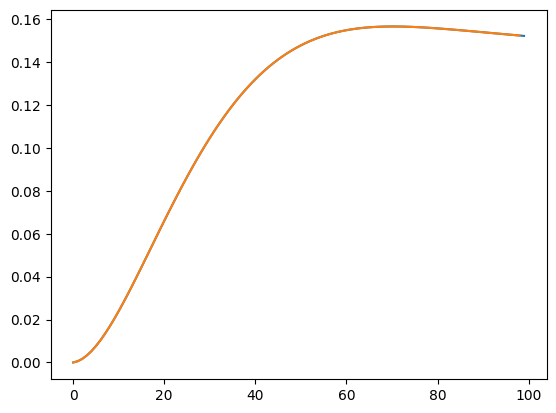

In [15]:
def check_with_lqr (env, lqr):
    state = env.reset ()
    I = 0.25
    b = 0.2
    N = 100
    T = 0.01
    roh = 0.01
    A = np.array([[1, T], [0, 1 - T*b/I]])
    B = np.array([[0], [T/I]])
    C = np.array([[1, 0]])
    Qf = C.T @ C
    Q = Qf
    R = roh 
    x_lqr, y, u_lqr, J = LQR(A, B, C, Q, Qf, R, N)
    x_env = []
    for i in range(N):
        action = u_lqr[i].reshape(-1)
        next_state, reward, is_done, *_ = env.step(action)
        x_env.append(next_state)
        if is_done:
            break
    return(x_env, u_lqr, x_lqr)

(x_env, u_lqr, x_lqr) = check_with_lqr(env, LQR)

plt.figure()
plt.plot(0.15 - np.array(x_env)[:,0])
plt.plot(0.15 - np.array(x_lqr)[1:,0])    

With the function check_with_lqr, the curves describe the same mouvement so the environment generated the same trajectory as LQR

### 3 Using PPO to find the optimal control law


Task 9. Train the policy using PPO. To do so, use the following snippet:


In [350]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
env = ForeArmModel()  # Construct the environment
env = DummyVecEnv([lambda: env])  # Wrap the environment in DummyVecEnv
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./PPO_ForeArm/")  # Correct the policy name

model.learn(total_timesteps=int(5e5))  # Train the agent
model.save("ppo_forearm")  # Save the trained agent for reuse


Using cpu device
Logging to ./PPO_ForeArm/PPO_4
-----------------------------
| time/              |      |
|    fps             | 1680 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1128         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0077599827 |
|    clip_fraction        | 0.0825       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.273        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0318       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00933     |
|    std                  | 0.998        |
|    value_

Task 10. Compare the obtained policy with that from the LQR.


[[0.15 0.  ]]
100


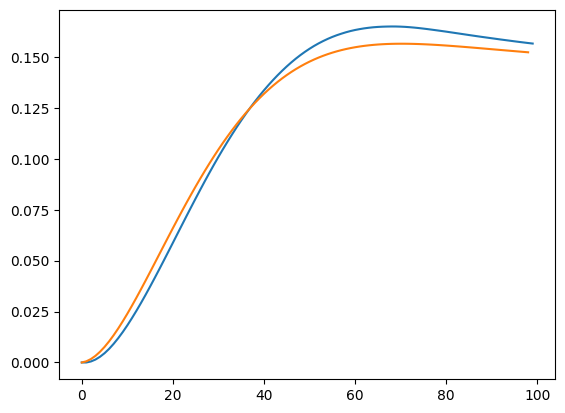

In [361]:
from stable_baselines3 import PPO

model = PPO.load("ppo_forearm.zip")  # Load the computed optimal policy

env = ForeArmModel()  # Load the environment
env = DummyVecEnv([lambda: env])  # Wrap the environment in DummyVecEnv

obs = env.reset()  # Reset env
state = []         # Keep track of the trajectory
state.append(obs)  # Add the initial state
print(obs)
while True:
    action, _states = model.predict(obs)   # Get the optimal action given the current state
    obs, reward, done, info = env.step(action)  # Make the action
    state.append(obs)  # Keep track of the state
    if done:
        break
state = np.array(state)[:-1, 0, :]
print(len(state))
plt.figure()
plt.plot(0.15 - state[:, 0])
plt.plot(0.15 - np.array(x_lqr)[1:, 0])


The trajectory with the trained policy follows approximately the one of LQR but the model needs more time to train if one want to get the same trajectory.